# CARMENES / GTO DATABASE LOADING AND INSPECTION
# Locating GTO objects in instability strips
(With pandas)

## Modules and configuration

### Modules

In [1]:
# Modules import:
import numpy as np

import pandas as pd
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})
#sns.set_style("whitegrid")
#sns.set(rc={'figure.figsize':(15,8)})

### Configuration

In [2]:
# Configuration:
# Files:
INPUT_FILE = "../data/carmencita.102_mod.csv"
OUTPUT_FILE = INPUT_FILE[:-4] + "2.csv"
GTO_OUTPUT_FILE = INPUT_FILE[:-4] + "2_GTO.csv"
IMAGE_NOMINAL_OUT = "./img/ETL_10_01_GTO_Instability_bands_Nominal.png"
IMAGE_RANGED_OUT = "./img/ETL_10_02_GTO_Instability_bands_Ranged.png"

# Instability bands:
INST_B = {
    'D-burning': {
        'logg': {
            'min': 3.1,
            'max': 3.6
        },
        'Teff': {
            'min': 2800,
            'max': 3500
        }
    },
    'He3-burning': {
        'logg': {
            'min': 4.5,
            'max': 5.1
        },
        'Teff': {
            'min': 3300,
            'max': 4300
        }
    }
}




## Data loading

In [3]:
carmenes = pd.read_csv(INPUT_FILE, sep=',', decimal='.')
carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Survey,Notes,Gaia_id_1,2MASS_id,TIC_id,Teff_min_K,Teff_max_K,logg_min,logg_max,is_GTO
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,NaN,NaN,1927517417630958208,23594940+4745447,177697529,2950.0,3050.0,4.50,5.50,False
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,NaN,NaN,2846620421604285568,23590042+2051387,2053997903,NaN,NaN,NaN,NaN,False
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,NaN,# WDS BAG34 consistent wtih Hei415.,1927184643563033856,23584342+4643452,2041238829,NaN,NaN,NaN,NaN,False
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,GTO,NaN,2746709861572970624,23583264+0739304,408486498,3476.0,3516.0,4.89,5.05,True
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,NaN,#20-150Ma Shk09.,2414454421367861376,23581366-1724338,2052312661,NaN,NaN,NaN,NaN,False


In [4]:
print(carmenes.columns.tolist())

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

## Mark instability band (if appropriate)

### With nominal values (using just `logg` variable)

In [5]:
carmenes['InstBand_nominal'] = "none"

In [6]:
# Mark stars in instability bands (using nominal values):
for ib in INST_B.keys():
    carmenes.loc[(carmenes['logg'] >= INST_B[ib]['logg']['min']) &
                 (carmenes['logg'] <= INST_B[ib]['logg']['max']) &
                 (carmenes['Teff_K'] >= INST_B[ib]['Teff']['min']) &
                 (carmenes['Teff_K'] <= INST_B[ib]['Teff']['max']),
                 'InstBand_nominal'] = ib

carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Notes,Gaia_id_1,2MASS_id,TIC_id,Teff_min_K,Teff_max_K,logg_min,logg_max,is_GTO,InstBand_nominal
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,NaN,1927517417630958208,23594940+4745447,177697529,2950.0,3050.0,4.50,5.50,False,none
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,NaN,2846620421604285568,23590042+2051387,2053997903,NaN,NaN,NaN,NaN,False,none
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,# WDS BAG34 consistent wtih Hei415.,1927184643563033856,23584342+4643452,2041238829,NaN,NaN,NaN,NaN,False,none
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,NaN,2746709861572970624,23583264+0739304,408486498,3476.0,3516.0,4.89,5.05,True,He3-burning
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,#20-150Ma Shk09.,2414454421367861376,23581366-1724338,2052312661,NaN,NaN,NaN,NaN,False,none


Check the total number of stars in instability bands (nominal):

In [7]:
carmenes['InstBand_nominal'].value_counts()

none           1231
He3-burning     981
Name: InstBand_nominal, dtype: int64

**OBSERVATION:** no star at all is in the instability strip of _"D-burning"_ cases.

Check the GTO stars in instability bands (nominal):

In [8]:
carmenes.loc[carmenes['is_GTO'] == True, 'InstBand_nominal'].value_counts()

He3-burning    224
none           139
Name: InstBand_nominal, dtype: int64

### With ranged values (including  `elogg` variable)

We first check the max values of `eTeff_K` and `elogg`, just in case the instability bands could overlap and hence provoke ambiguous band assignation.

In [9]:
INST_B

{'D-burning': {'logg': {'min': 3.1, 'max': 3.6},
  'Teff': {'min': 2800, 'max': 3500}},
 'He3-burning': {'logg': {'min': 4.5, 'max': 5.1},
  'Teff': {'min': 3300, 'max': 4300}}}

In [10]:
carmenes[['eTeff_K', 'elogg']].describe()

,eTeff_K,elogg
count,1657.000000,1652.000000
mean,45.379602,0.410533
std,11.216744,0.160944
min,9.000000,0.030000
25%,50.000000,0.500000
50%,50.000000,0.500000
75%,50.000000,0.500000
max,97.000000,0.500000


Maximum value of `elogg` is $0.5$, so the assignment to instability bands will not be ambiguous.

In [11]:
carmenes.columns

Index(['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg',
       'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg',
       ...
       'Notes', 'Gaia_id_1', '2MASS_id', 'TIC_id', 'Teff_min_K', 'Teff_max_K',
       'logg_min', 'logg_max', 'is_GTO', 'InstBand_nominal'],
      dtype='object', length=181)

In [12]:
carmenes['InstBand_ranged'] = "none"

In [13]:
# Mark stars in instability bands (ussing range of values):
for ib in INST_B.keys():
    mask_range_logg = ((carmenes['logg_min'] >= INST_B[ib]['logg']['min']) & \
                   (carmenes['logg_min'] <= INST_B[ib]['logg']['max'])) | \
                ((carmenes['logg_max'] >= INST_B[ib]['logg']['min']) & \
                 (carmenes['logg_max'] <= INST_B[ib]['logg']['max']))
    mask_range_Teff = ((carmenes['Teff_min_K'] >= INST_B[ib]['Teff']['min']) & \
                   (carmenes['Teff_min_K'] <= INST_B[ib]['Teff']['max'])) | \
                ((carmenes['Teff_max_K'] >= INST_B[ib]['Teff']['min']) & \
                 (carmenes['Teff_max_K'] <= INST_B[ib]['Teff']['max']))
    carmenes.loc[mask_range_logg & mask_range_Teff,
                 'InstBand_ranged'] = ib

carmenes.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,Gaia_id_1,2MASS_id,TIC_id,Teff_min_K,Teff_max_K,logg_min,logg_max,is_GTO,InstBand_nominal,InstBand_ranged
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,1927517417630958208,23594940+4745447,177697529,2950.0,3050.0,4.50,5.50,False,none,none
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,2846620421604285568,23590042+2051387,2053997903,NaN,NaN,NaN,NaN,False,none,none
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,1927184643563033856,23584342+4643452,2041238829,NaN,NaN,NaN,NaN,False,none,none
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,2746709861572970624,23583264+0739304,408486498,3476.0,3516.0,4.89,5.05,True,He3-burning,He3-burning
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,2414454421367861376,23581366-1724338,2052312661,NaN,NaN,NaN,NaN,False,none,none


Check the total number of stars in instability bands (ranged):

In [14]:
carmenes['InstBand_ranged'].value_counts()

He3-burning    1157
none           1055
Name: InstBand_ranged, dtype: int64

Check the GTO stars in instability bands (nominal):

In [15]:
carmenes.loc[carmenes['is_GTO'] == True, 'InstBand_ranged'].value_counts()

He3-burning    259
none           104
Name: InstBand_ranged, dtype: int64

### Summary of stats

In [16]:
carmenes[['is_GTO', 'InstBand_nominal', 'Karmn']] \
    .groupby(by=['is_GTO', 'InstBand_nominal']).count()

Karmn
is_GTO InstBand_nominal       
False  He3-burning         757
       none               1092
True   He3-burning         224
       none                139

In [17]:
carmenes[['is_GTO', 'InstBand_ranged', 'Karmn']] \
    .groupby(by=['is_GTO', 'InstBand_ranged']).count()

Karmn
is_GTO InstBand_ranged       
False  He3-burning        898
       none               951
True   He3-burning        259
       none               104

Check `Nan` values of the data (`Teff_K` and `logg`variables):

In [18]:
carmenes[['Teff_K', 'logg']].isna().sum().reset_index()

,index,0
0,Teff_K,555
1,logg,560


In [19]:
carmenes[carmenes['is_GTO'] == True][['Teff_K', 'logg']].isna().sum().reset_index()

,index,0
0,Teff_K,0
1,logg,4


## Data visualization

In [20]:
gto = carmenes[carmenes['is_GTO'] == True].copy()

gto.shape

(363, 182)

### Only GTO objects

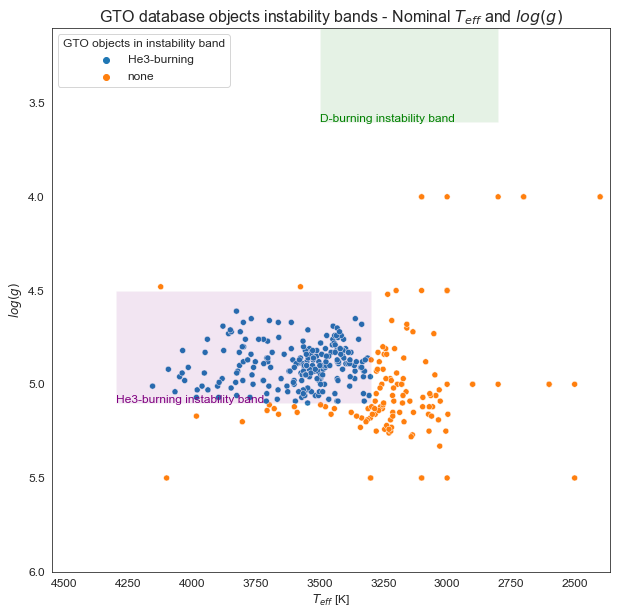

In [21]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_nominal')
# Set plot limits as per global CARMENES data values.
x_min = min([INST_B['He3-burning']['Teff']['min'], INST_B['D-burning']['Teff']['min'],
             carmenes['Teff_min_K'].min()])
x_max = max([INST_B['He3-burning']['Teff']['max'], INST_B['D-burning']['Teff']['max'],
             carmenes['Teff_max_K'].max()])
y_min = min([INST_B['He3-burning']['logg']['min'], INST_B['D-burning']['logg']['min'],
             carmenes['logg_min'].min()])
y_max = max([INST_B['He3-burning']['logg']['max'], INST_B['D-burning']['logg']['max'],
             carmenes['logg_max'].max()])
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
# Add and label instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.10))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12)
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.10))
ax.text(4300, 5.1, "He3-burning instability band", color="purple", fontsize=12)
# Set titles, sizes etc.
ax.set_title("GTO database objects instability bands - Nominal $T_{eff}$ and $log(g)$", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="GTO objects in instability band", title_fontsize='large',
           loc='best', fontsize=12)
plt.savefig(IMAGE_NOMINAL_OUT)
plt.show();

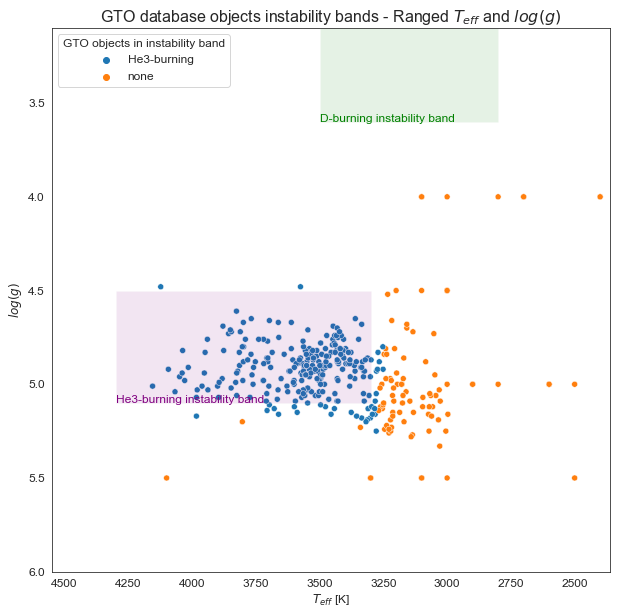

In [22]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=gto, x='Teff_K', y='logg', hue='InstBand_ranged')
# Set plot limits as per global CARMENES data values.
x_min = min([INST_B['He3-burning']['Teff']['min'], INST_B['D-burning']['Teff']['min'],
             carmenes['Teff_min_K'].min()])
x_max = max([INST_B['He3-burning']['Teff']['max'], INST_B['D-burning']['Teff']['max'],
             carmenes['Teff_max_K'].max()])
y_min = min([INST_B['He3-burning']['logg']['min'], INST_B['D-burning']['logg']['min'],
             carmenes['logg_min'].min()])
y_max = max([INST_B['He3-burning']['logg']['max'], INST_B['D-burning']['logg']['max'],
             carmenes['logg_max'].max()])
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
# Add and label instability regions:
ax.add_patch(mpatches.Rectangle((2800, 3.1), 700, 0.5, facecolor="green", alpha=0.10))
ax.text(3500, 3.6, "D-burning instability band", color="green", fontsize=12)
ax.add_patch(mpatches.Rectangle((3300, 4.5), 1000, 0.6, facecolor="purple", alpha=0.10))
ax.text(4300, 5.1, "He3-burning instability band", color="purple", fontsize=12)
# Set titles, sizes etc.
ax.set_title("GTO database objects instability bands - Ranged $T_{eff}$ and $log(g)$", fontsize=16)
ax.set_xlabel("$T_{eff}$ [K]", fontsize=12)
ax.set_ylabel("$log(g)$", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.invert_xaxis()
ax.invert_yaxis()
plt.legend(title="GTO objects in instability band", title_fontsize='large',
           loc='best', fontsize=12)
plt.savefig(IMAGE_RANGED_OUT)
plt.show();

## Save newly modified data

In [23]:
carmenes.to_csv(OUTPUT_FILE, sep=',', decimal='.', index=False)

In [24]:
carmenes[carmenes['is_GTO'] == True].to_csv(GTO_OUTPUT_FILE, sep=',', decimal='.', index=False)

## Summary

**OBSERVATIONS AND CONCLUSSIONS:**
- From the GTO sample, we have 224 stars in the _"He3-burning"_ instability band ($\approx62\%$ of the sample).
- If we take into account the error margins in the `logg` and `Teff_K` variables, the number increases slightly to 259 stars ($\approx71\%$ of the sample))
- The percentages in the _"He3-burning"_ instability bands for the sample of non-GTO stars are $\approx41\%$ (nominal) and $\approx49\%$ (ranged).
- Hence, a greater fraction of GTO stars are prone to belong to the _"He3-burning"_ instability band.
- No star in the total _CARMENES_ sample is located in the _"D-burning"_ stability band.
- Notice that some stars in the database have no `Teff_K` or `logg` values, so their belonging to instability bands is unknown:
  - 4 GTO stars have no `logg`value.
  - 555 non-GTO stars have no `Teff_K`value; 556 non-GTO stars have no `logg` value.